<a href="https://colab.research.google.com/github/Rohankola/ML_homework/blob/main/lab2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, train=True, transform=train_transform, target_transform=None, download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, train=False, transform=test_transform, target_transform=None, download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              Tanh-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
              Tanh-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 337,674
Trainable params: 337,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.29
Estimated Total Size (MB): 1.31
----------------------------------------------------------------


Your experiments come here:

In [9]:
def train_epoch(model, device, train_loader, test_loader, criterion, optimizer): 
    torch.manual_seed(5)

    model.train()

    current_test_accuracy = 0
    running_loss = 0
    pred = 0
    correct = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    
    current_loss = running_loss / len(train_loader.dataset)
    print(f'train loss = {current_loss}')
    current_train_accuracy = correct / len(train_loader.dataset)
    print(f'train accuracy = {current_train_accuracy}')

    model.eval()

    current_test_loss = 0
    current_test_accuracy = 0 

    test_loss = 0
    correct = 0   
    running_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss = criterion(output, label)
            running_loss += test_loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    current_test_loss = running_loss / len(test_loader.dataset) 
    print(f'test loss = {current_test_loss}')
    current_test_accuracy = correct / len(test_loader.dataset)
    print(f'test accuracy = {current_test_accuracy}')

    return current_loss, current_train_accuracy, current_test_loss, current_test_accuracy



In [10]:
def train_model(epochs, model, device, train_loader, test_loader, loss_func, opt):
    test_loss_history = list()
    train_loss_history = list()
    test_ac_history = list()
    train_ac_history = list()

    train_loss = 0
    test_loss = 0
    test_ac = 0
    train_ac = 0
    for epoch in range(1, epochs+1):
        
        #print(f'epoch {epoch}')
        train_loss, train_ac, test_loss, test_ac = train_epoch(model, device, train_loader, test_loader, loss_func, opt)
        

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_ac_history.append(test_ac)
        train_ac_history.append(train_ac)

    return train_loss_history, test_loss_history, train_ac_history, test_ac_history

In [11]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_func = nn.CrossEntropyLoss()
epochs = 30

In [12]:
train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.004719251390298208
train accuracy = 0.7889666666666667
test loss = 0.0019346679136157036
test accuracy = 0.8226
train loss = 0.0032267372615635394
train accuracy = 0.8514333333333334
test loss = 0.0017770216777920722
test accuracy = 0.8373
train loss = 0.0029673258910576502
train accuracy = 0.8634833333333334
test loss = 0.001688254602253437
test accuracy = 0.8443
train loss = 0.002800897358109554
train accuracy = 0.8705833333333334
test loss = 0.0016245910361409187
test accuracy = 0.8498
train loss = 0.002672674437860648
train accuracy = 0.8761
test loss = 0.0015758523777127265
test accuracy = 0.8541
train loss = 0.0025661857922871906
train accuracy = 0.8808333333333334
test loss = 0.0015374183639883996
test accuracy = 0.8587
train loss = 0.002474072730789582
train accuracy = 0.88445
test loss = 0.0015049109637737274
test accuracy = 0.8617
train loss = 0.0023921610857049625
train accuracy = 0.8882166666666667
test loss = 0.0014752273187041284
test accuracy = 0.8632
trai

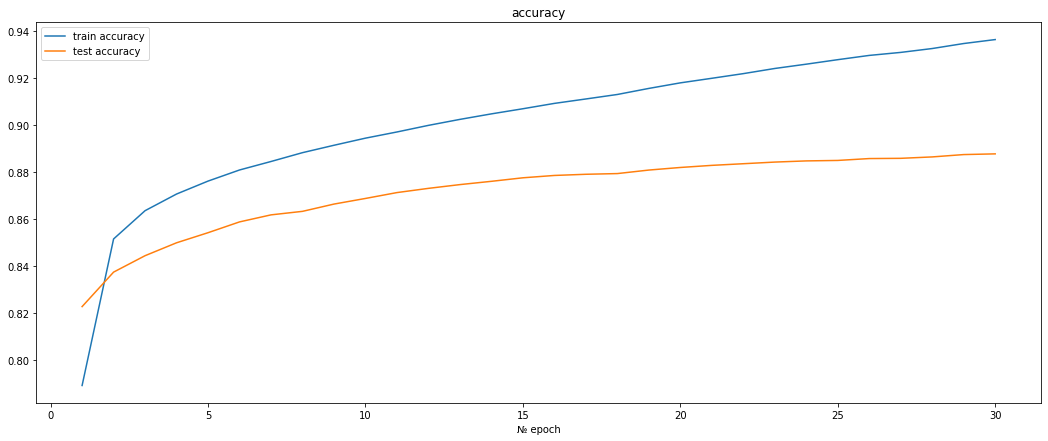

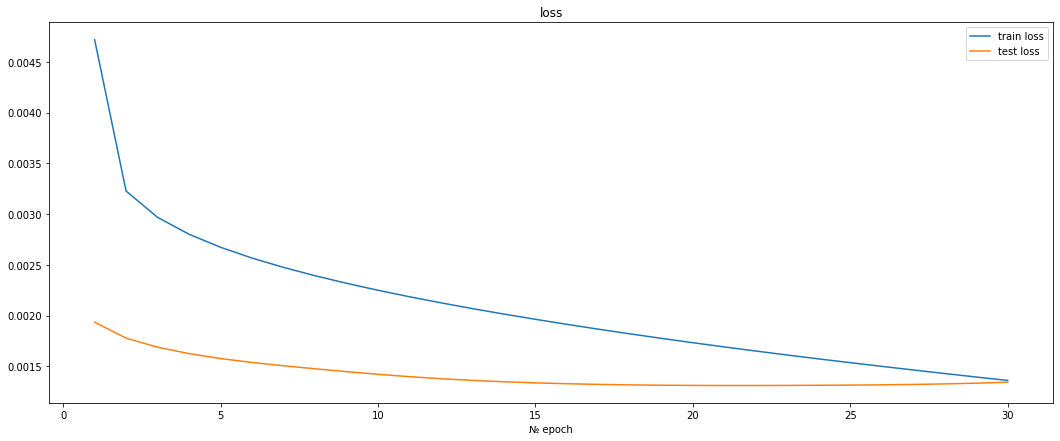

In [13]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

##### accuracy

In [14]:
print(f'Test accuracy = {test_ac_history[-1]}')

Test accuracy = 0.8877


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 512]         803,328
              Tanh-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 2,192,246
Trainable params: 2,192,246
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 8.36
Estimat

In [18]:
model_over = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model_over.parameters(), lr=0.0003)
loss_func = nn.CrossEntropyLoss()

epochs = 50

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_over, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.004596658498545488
train accuracy = 0.7913833333333333
test loss = 0.0017197856768965721
test accuracy = 0.8413
train loss = 0.0029420729503035546
train accuracy = 0.8636833333333334
test loss = 0.0015917626060545445
test accuracy = 0.8523
train loss = 0.0026147327808042366
train accuracy = 0.87625
test loss = 0.0015583962589502335
test accuracy = 0.8567
train loss = 0.0023882641181349755
train accuracy = 0.8865666666666666
test loss = 0.0015352773383259773
test accuracy = 0.857
train loss = 0.0022192850927511853
train accuracy = 0.8942666666666667
test loss = 0.0014564947471022605
test accuracy = 0.8648
train loss = 0.002074147795761625
train accuracy = 0.9012833333333333
test loss = 0.0014273597940802575
test accuracy = 0.8684
train loss = 0.0019514464141180117
train accuracy = 0.9071833333333333
test loss = 0.0013609300062060357
test accuracy = 0.8756
train loss = 0.0018494739575932422
train accuracy = 0.91135
test loss = 0.0013547944515943527
test accuracy = 0.8777
t

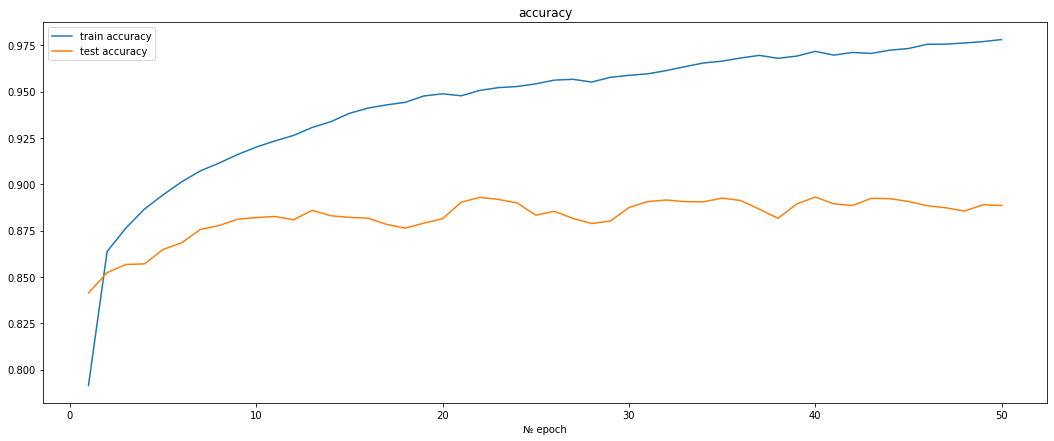

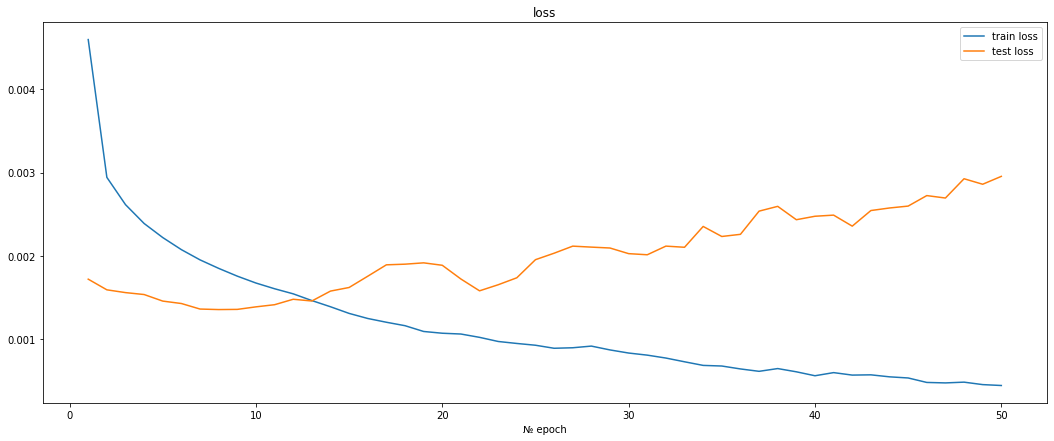

In [19]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.BatchNorm1d(28*28*2),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Dropout(0.8),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, 100),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
           Dropout-4                 [-1, 1568]               0
              ReLU-5                 [-1, 1568]               0
            Linear-6                  [-1, 512]         803,328
           Dropout-7                  [-1, 512]               0
              Tanh-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 100]          25,700
          Dropout-14                  [

In [22]:
model_fix = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model_fix.parameters(), lr=0.0003, weight_decay=0.008)
loss_func = nn.CrossEntropyLoss()

epochs = 20

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_fix, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.016076600696643194
train accuracy = 0.2195
test loss = 0.004739337372779846
test accuracy = 0.4857
train loss = 0.009651447264353434
train accuracy = 0.49866666666666665
test loss = 0.003846901571750641
test accuracy = 0.6582
train loss = 0.007094004660844803
train accuracy = 0.6249
test loss = 0.0033529096007347105
test accuracy = 0.7198
train loss = 0.0057714991768201196
train accuracy = 0.7065833333333333
test loss = 0.003188281548023224
test accuracy = 0.7532
train loss = 0.00484221233278513
train accuracy = 0.7704166666666666
test loss = 0.002960851263999939
test accuracy = 0.766
train loss = 0.004161655157307783
train accuracy = 0.8132833333333334
test loss = 0.0027728478997945784
test accuracy = 0.759
train loss = 0.0036668229242165884
train accuracy = 0.8469
test loss = 0.0027887303590774537
test accuracy = 0.7705
train loss = 0.003291658753156662
train accuracy = 0.8692333333333333
test loss = 0.002556157076358795
test accuracy = 0.7812
train loss = 0.0030029462

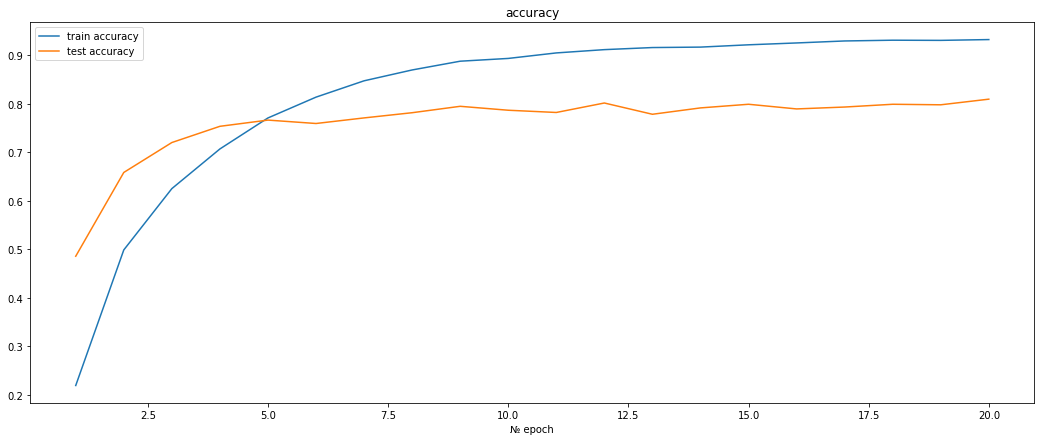

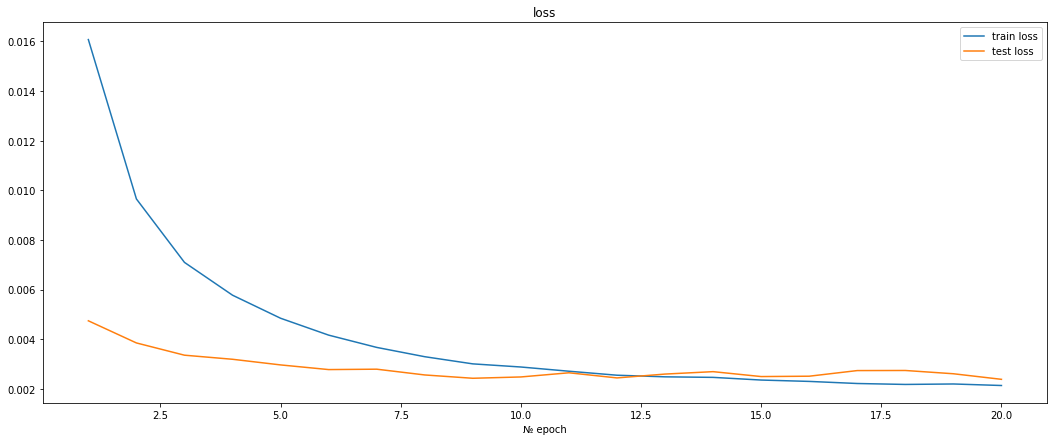

In [23]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

### Conclusion:

Of these three methods, the last one turned out to be the best.